# What is the purpose of this progect?
In this project, first we will train a YOLOv8 model on a custom dataset of "Kidney Stone" MRI images from [Kaggle](https://www.kaggle.com/datasets/safurahajiheidari/kidney-stone-images) to detect the location of kedney stone in each Image!
Although YOLO provides segementation tools we will try to be more creactive and choose a harder path :)))
After the training step is done, we will try to get the coordinates of predicted bounding boxes on couple of test images. Then we will those bounding boxes as ROI and pass them to SAM(Segment Anything Model) to segment those regions for us.
The result will be good, I'm sure!!!

# Whom I'd like to thanks?
I want to say thanks to [Ultralytics](https://www.ultralytics.com/) for the YOLOv8!

Also I'd like to tip my hat to [Roboflow's Blog](https://blog.roboflow.com/) for the learning materials that gave me a Motivation to do this project.

## First part of the Code.

In [ ]:
# Importing and inatalling packages we will use for this notebook
!pip install ultralytics
!pip install kaggle
!sudo apt-get install tree
!pip install -q roboflow  supervision
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
import os
import shutil
import numpy as np
import random
import cv2
import torch
import supervision as sv
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import files
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [3]:
# If after installing kaggle can't see a directory named ".kaggle" in your root directory
# simply create one because you'll need it to put your kaggle.json file in it.
# you can check this using this command ==> !ls -la /root
!mkdir /root/.kaggle

In [4]:
# Create an API token in your kaggle profile and and upload it here
## !!!!! keep that file somewhere safe!!!!
# Upload your Kaggle API credentials JSON file here
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
# Move the uploaded file to the correct directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [6]:
# Set permissions for Kaggle API credentials
os.chmod('/root/.kaggle/kaggle.json', 600)

In [7]:
# Use Kaggle API command to download the dataset
!kaggle datasets download -d safurahajiheidari/kidney-stone-images

 90% 19.0M/21.1M [00:00<00:00, 50.4MB/s]
100% 21.1M/21.1M [00:00<00:00, 54.0MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/kidney-stone-images.zip -d /content/kidney-stone-images

In [9]:
# Taking a look at our dataset directory structure
!tree -L 2 --dirsfirst /content/kidney-stone-images

/content/kidney-stone-images
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── valid
│   ├── images
│   └── labels
├── data.yaml
├── README.dataset.txt
└── README.roboflow.txt

9 directories, 3 files


## Visualizing some images from train set

Now I'll show 5 random images from our training set next to labeled images with bounding boxes. The YOLOv8 format typically has bounding box coordinates normalized relative to the width and height of the image, in the format [class, x_center, y_center, width, height]. We need to convert these normalized values to actual pixel coordinates for drawing.

In [ ]:
# Set the paths to the directories
image_dir = '/content/kidney-stone-images/train/images'
bbox_dir = '/content/kidney-stone-images/train/labels'

# Function to read and convert bounding box coordinates from a file
def read_bboxes(file_path, img_shape):
    with open(file_path, 'r') as file:
        bboxes = []
        for line in file:
            # YOLO format: class, x_center, y_center, width, height (normalized)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center, y_center, width, height = x_center * img_shape[1], y_center * img_shape[0], width * img_shape[1], height * img_shape[0]
            x, y = int(x_center - width / 2), int(y_center - height / 2)
            bboxes.append([int(x), int(y), int(width), int(height)])
    return bboxes

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    return image

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:5]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.suptitle('Original and Labeled Images')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)

    # Show original and labeled images
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Train Image')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Train Image with bounding box')

plt.tight_layout()
plt.show()

In [11]:
# Configuring the data.yaml file for this project and editing related directories
import yaml
config = {'path': '/content/kidney-stone-images',
         'train': '/content/kidney-stone-images/train',
         'val': '/content/kidney-stone-images/valid',
         'nc': 1,
         'names': ['Tas_Var']}

with open("/content/kidney-stone-images/data.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

Loading The pretrained model

In [12]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 137MB/s]




We will now train the model on the custom dataset for 30 epochs.Actually we will start with the pre-trained weights and fine tune them for our purpose.

Tip : make sure you're using a GPU for training:


In [13]:
# If you are using a GPU you'd get a result like below otherwise something like this may appear :
#/bin/bash: line 1: nvidia-smi: command not found

!nvidia-smi

Thu Dec 21 23:26:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Training the model on train Images

In [14]:
# Training
result = model.train(data='/content/kidney-stone-images/data.yaml',epochs=30)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/kidney-stone-images/data.yaml, epochs=30, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 16.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.2MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/kidney-stone-images/train/labels... 1054 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:01<00:00, 939.79it/s] 

train: New cache created: /content/kidney-stone-images/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/kidney-stone-images/valid/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 570.38it/s]

val: New cache created: /content/kidney-stone-images/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.12G      2.341      2.576      1.402         41        640: 100%|██████████| 66/66 [00:40<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        123        325     0.0878      0.172     0.0255      0.008



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.27G      2.168      1.389       1.34         39        640: 100%|██████████| 66/66 [00:36<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        123        325      0.525      0.517       0.44      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.25G      2.213      1.358      1.346         47        640: 100%|██████████| 66/66 [00:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        123        325    0.00298      0.311    0.00198   0.000868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.32G      2.186      1.226      1.324         33        640: 100%|██████████| 66/66 [00:32<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        123        325      0.581      0.568      0.513      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.29G      2.132      1.207      1.345         49        640: 100%|██████████| 66/66 [00:36<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        123        325      0.563      0.471      0.448      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.28G      2.121      1.176      1.302         51        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        123        325      0.621       0.53      0.546      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.34G      2.078      1.153        1.3         61        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        123        325      0.599      0.668      0.603      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.31G      2.088      1.187      1.286         37        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        123        325      0.668      0.526      0.511      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       7.3G      2.086      1.114      1.275         28        640: 100%|██████████| 66/66 [00:36<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        123        325      0.733      0.625      0.618      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.31G      2.035      1.045      1.256         26        640: 100%|██████████| 66/66 [00:36<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        123        325      0.655      0.643      0.572      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.29G      2.069      1.037      1.277         54        640: 100%|██████████| 66/66 [00:38<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        123        325      0.701      0.615      0.628      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.34G      2.016      1.043      1.233         52        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        123        325       0.77      0.625      0.618      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.29G       2.01      1.064      1.246         43        640: 100%|██████████| 66/66 [00:35<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        123        325      0.768      0.652      0.706      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       7.3G      1.954     0.9617      1.231         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        123        325      0.743      0.665      0.657      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.33G      1.999     0.9945      1.259         46        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        123        325      0.731      0.674       0.68      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.33G       1.97     0.9989      1.221         57        640: 100%|██████████| 66/66 [00:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        123        325      0.709      0.662      0.692      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.34G      1.963     0.9774      1.231         54        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        123        325      0.783      0.662      0.699      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.28G      1.939     0.9473      1.217         35        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        123        325      0.776      0.661      0.687      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.29G      1.972     0.9811      1.214         85        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        123        325      0.747      0.702      0.698      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.31G      1.926     0.9628      1.224         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        123        325      0.792       0.72      0.738      0.315


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.29G       1.94     0.9822      1.274         38        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        123        325      0.776       0.72      0.713      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       7.3G      1.916     0.9464      1.256         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        123        325      0.748      0.714      0.733      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.29G      1.908      0.938      1.253         29        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        123        325      0.789      0.714      0.734      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.29G      1.875     0.9273      1.241         32        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        123        325      0.821      0.689      0.739      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.29G      1.866     0.8932       1.22         19        640: 100%|██████████| 66/66 [00:34<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        123        325       0.78      0.722      0.739      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.31G       1.89     0.8945      1.232         19        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        123        325      0.776      0.726      0.745      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.29G       1.82     0.8678      1.197         26        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        123        325      0.815      0.751      0.763      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.29G      1.807     0.8654      1.206         25        640: 100%|██████████| 66/66 [00:33<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        123        325      0.798      0.735      0.755      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.29G      1.792     0.8528      1.195         31        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        123        325      0.813      0.711      0.753      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.29G      1.781     0.8336      1.169         22        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        123        325      0.808       0.72      0.765      0.321



30 epochs completed in 0.327 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


                   all        123        325      0.809       0.72      0.765      0.321
Speed: 0.3ms preprocess, 9.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train


# Results

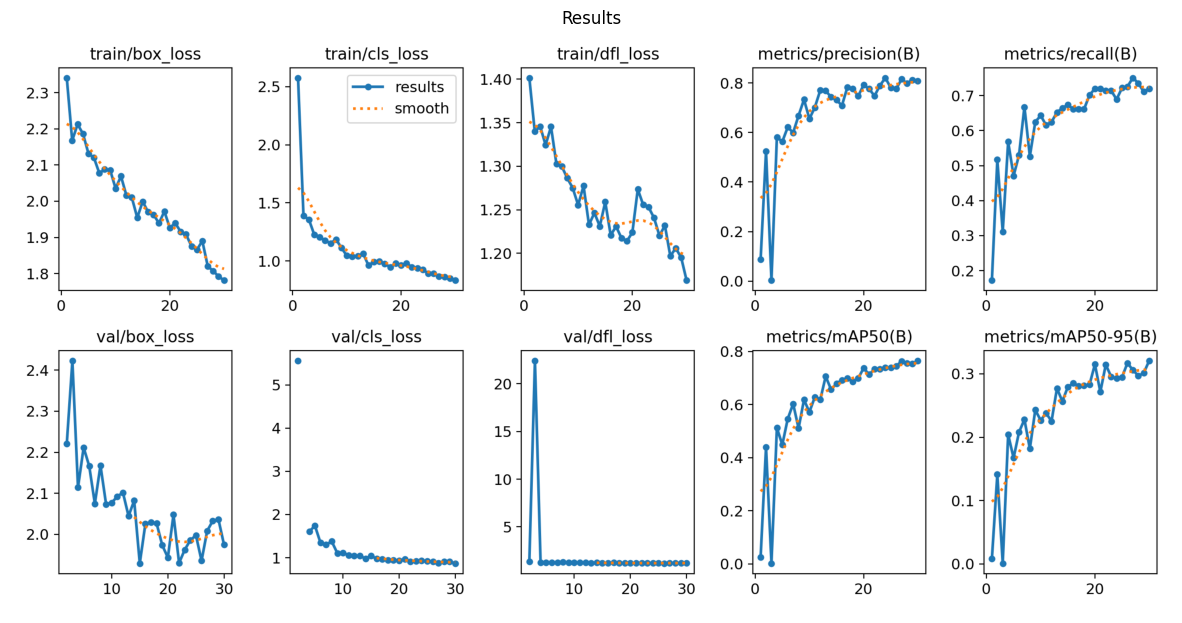

In [15]:
# take a look at learning process
result_curves = cv2.cvtColor(cv2.imread('/content/runs/detect/train/results.png'),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.title('Results')
plt.axis('off')
plt.imshow(result_curves)

Now we show some random images form test set with ground truth bounding boxes drawn on them and also the model prediction next to it.

In [ ]:
# Prediction on test set
model.predict('/content/kidney-stone-images/test/images',save=True,show_labels=False)

In [19]:
# Renaming the results directory
# The two first lines solve "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968" error
# You May not face it!
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mv /content/runs/detect/train2 /content/runs/detect/preds

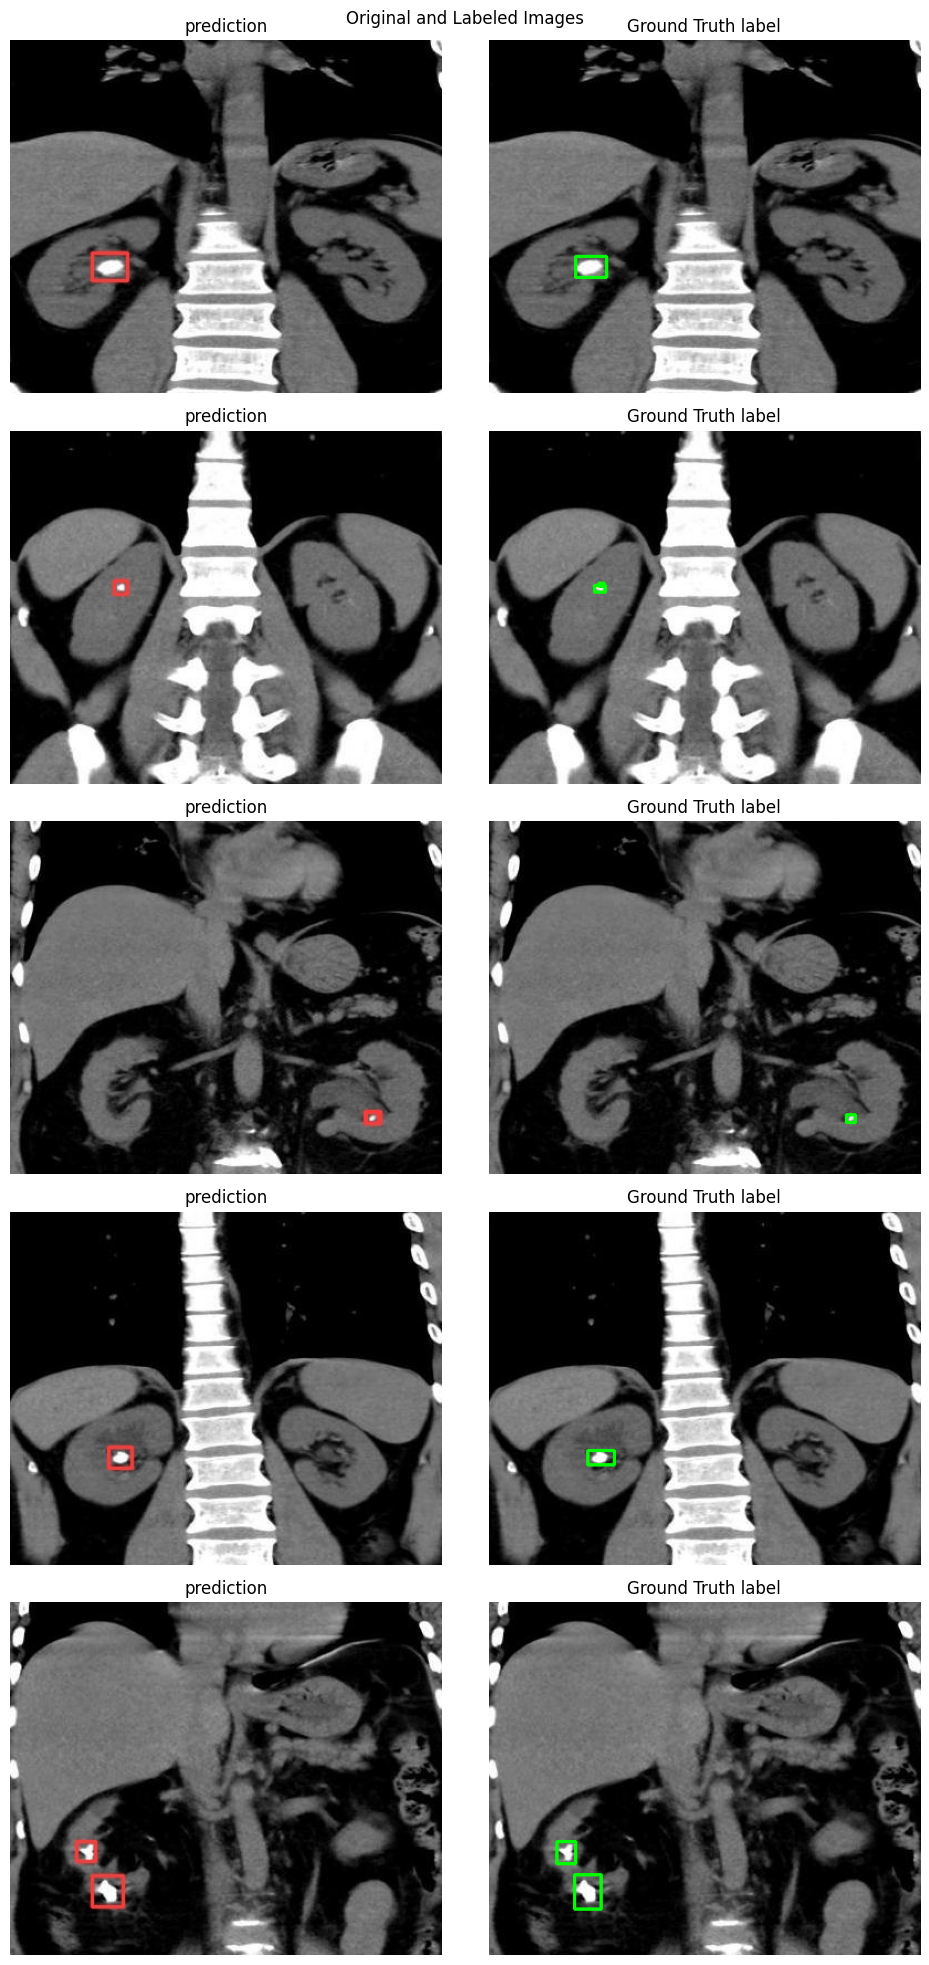

In [20]:
# Set the paths to the directories
image_dir = '/content/kidney-stone-images/test/images'
bbox_dir = '/content/kidney-stone-images/test/labels'

# Function to read and convert bounding box coordinates from a file
def read_bboxes(file_path, img_shape):
    with open(file_path, 'r') as file:
        bboxes = []
        for line in file:
            # YOLO format: class, x_center, y_center, width, height (normalized)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center, y_center, width, height = x_center * img_shape[1], y_center * img_shape[0], width * img_shape[1], height * img_shape[0]
            x, y = int(x_center - width / 2), int(y_center - height / 2)
            bboxes.append([int(x), int(y), int(width), int(height)])
    return bboxes

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:5]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.suptitle('Original and Labeled Images')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)
    prediction = cv2.cvtColor(cv2.imread('/content/runs/detect/preds/'+img_file), cv2.COLOR_BGR2RGB)
    # Show original and labeled images
    axes[i, 0].imshow(prediction)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('prediction')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth label')

plt.tight_layout()
plt.show()

# The cool part: Segmenting Kidney stones with SAM(Segment Anything Model)

In [21]:
# NOTE: To make it easier for us to manage datasets, images and models we create a HOME constant.
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [22]:
# Download SAM weights
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [23]:
# A quick sanity check to see if the weights are downloaded
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [24]:
# Loading the model
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In the Final step we segment the ROI's we get from YOLO predictions Using SAM and show the result.


0: 544x640 1 Tas_Var, 42.8ms
Speed: 3.3ms preprocess, 42.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 3 Tas_Vars, 17.5ms
Speed: 5.0ms preprocess, 17.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Tas_Var, 16.9ms
Speed: 3.2ms preprocess, 16.9ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Tas_Var, 19.1ms
Speed: 3.8ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Tas_Var, 18.1ms
Speed: 2.8ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 Tas_Vars, 18.1ms
Speed: 2.9ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Tas_Var, 18.4ms
Speed: 3.7ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 Tas_Var, 26.1ms
Speed: 2.7ms preprocess, 26.1ms inference, 7.6ms postprocess per image at shape

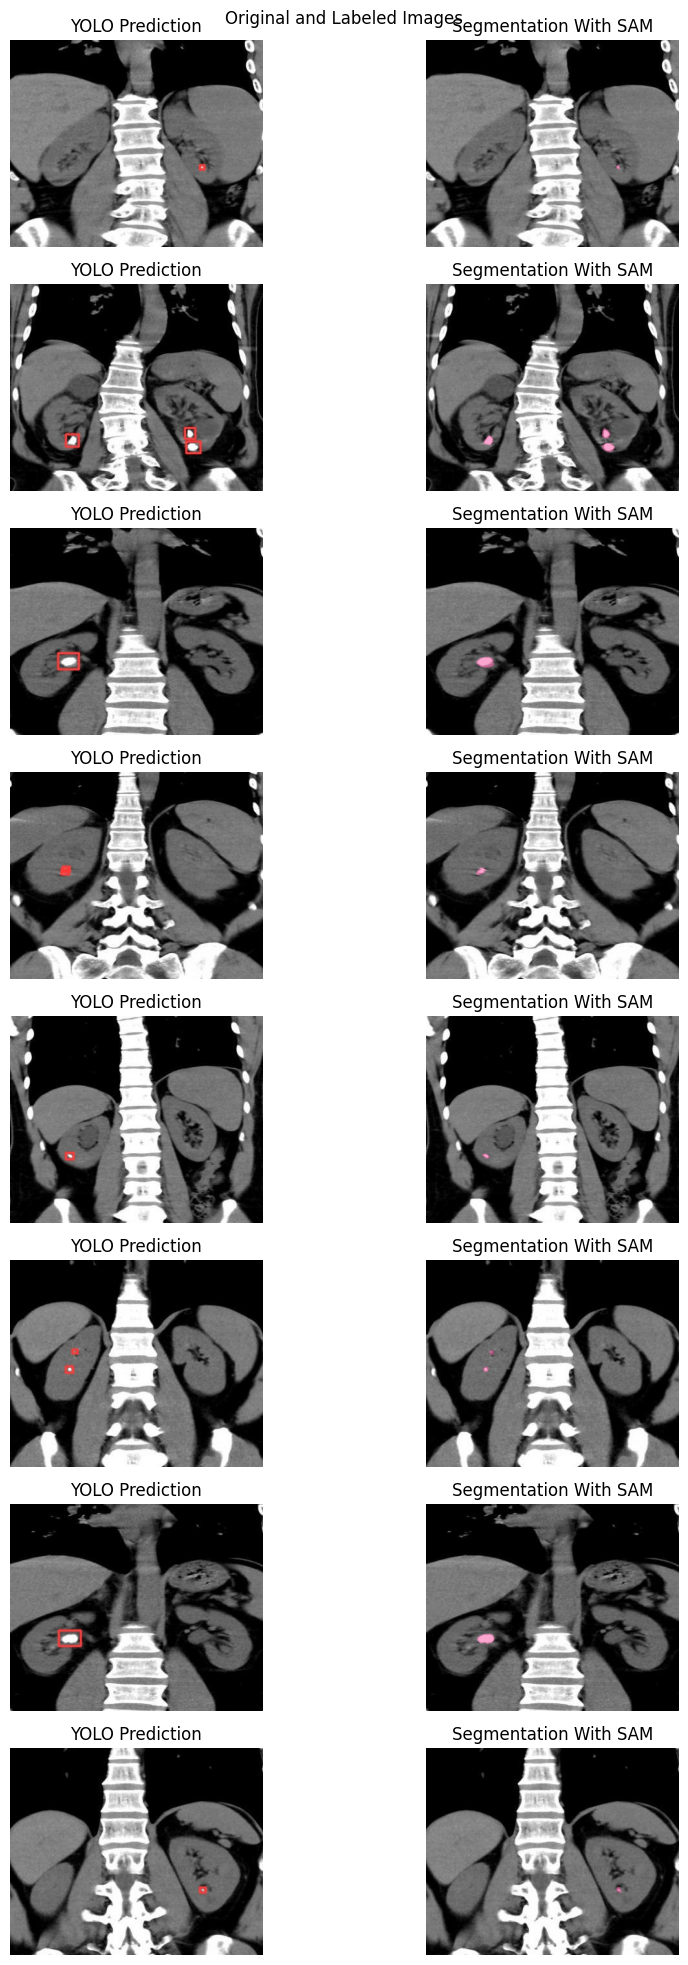

In [27]:
# Set the paths to the test images directory
image_dir = '/content/kidney-stone-images/test/images'

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 8 random images
selected_images = image_files[:8]

# Create subplots
fig, axes = plt.subplots(8, 2, figsize=(10, 20))
fig.suptitle('Original and Labeled Images')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)

    # Read prediction image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

    #predicting bounding box on test image with YOLO
    result = model([image],iou=0.70,conf=0.40)
    #NOTE: SamPredictor.predict method takes np.ndarray box argument in [x_min, y_min, x_max, y_max] format.
    #Let's get them from YOLO results
    boxes = result[0].boxes.xyxy.tolist()

    #segmenting the predictions
    for j in range(len(boxes)):
        mask_predictor.set_image(image)

        masks, scores, logits = mask_predictor.predict(
            box=np.array(boxes[j]),
            multimask_output=True
        )

        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks
        )
        detections = detections[detections.area == np.max(detections.area)]

        segmented_image = mask_annotator.annotate(scene=image, detections=detections)
        image = segmented_image


    # Show bounding box prediction and segmentation for that prediction
    axes[i, 0].imshow(cv2.cvtColor(cv2.imread('/content/runs/detect/preds/'+img_file),cv2.COLOR_RGB2BGR))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('YOLO Prediction')

    axes[i, 1].imshow(segmented_image)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Segmentation With SAM')

plt.tight_layout()
plt.show()